# Vehicle Routing Problem (VRP)

The Vehicle Routing Problem (VRP) is a well-known optimization problem in operations research that aims to find the optimal set of routes for a fleet of vehicles to visit a set of locations, subject to certain constraints.
The problem arises in many real-world scenarios such as package delivery, garbage collection, school bus routing, and many more. The goal is to minimize the total distance or time traveled by the vehicles while satisfying constraints such as capacity, time windows, and vehicle availability.

This project pertains to the optimization of delivery routes for three In's Supermarket trucks in Rome. The objective is to identify the shortest path for the trucks to transport goods from the depot to the delivery destination and subsequently return to the depot. The OpenStreetMap API is utilized to obtain accurate distance measurements between the relevant locations, and the VRP algorithm, implemented through Google OR-Tools, is employed to determine the optimal route.

### Importing libraries

In [87]:
# Import the necessary libraries
import osmnx as ox
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import FancyArrowPatch
from matplotlib import cm
from ortools.constraint_solver import pywrapcp
from ortools.constraint_solver import routing_enums_pb2

### Defining the location 

In [2]:
# Define the city you are interested in
city = 'Rome, Roma, Lazio, Italy'

# Download the road network data for the city
graph = ox.graph_from_place(city, network_type='drive')

### Creating distance matrix by OpenStreetMap API

In [4]:
center_point = (41.88193295890535, 12.619776330280022)
point_1 = (41.908621373972295, 12.451843389526827)
point_2 = (41.87601670475574, 12.46714063290324)
point_3 = (41.91145117364007, 12.50070733084591)
point_4 = (41.898347753189896, 12.513962742130182)
point_5 = (41.9089740816641, 12.526142601586148)
point_6 = (41.88157598436675, 12.515003286851687)
point_7 = (41.8831455681145, 12.524614468156614)
point_8 = (41.86632986157466, 12.527607363164517)
Point_9 = (41.898949822251915, 12.537586037153568)
point_10 = (41.8698670108551, 12.53540339880448)
point_11 = (41.880614044329306, 12.540577054594433)
point_12 = (41.881723521270324, 12.543075936516049)
point_13 = (41.91415322012547, 12.554589177418643)
point_14 = (41.90917790770905, 12.549287778654572)
Point_15 = (41.89131974745777, 12.552044411896036)
point_16 = (41.891456106812385, 12.560027651446832)
Point_17 = (41.89620530454831, 12.563819927661681)
point_18 = (41.865450064562786, 12.550454865082719)
point_19 = (41.863221244903556, 12.551379566587595)
point_20 = (41.861567455826666, 12.555502620143239)

points = [center_point, point_1, point_2, point_3, point_4, point_5, point_6, point_7, point_8,
          Point_9, point_10, point_11, point_12, point_13, point_14, Point_15, point_16, Point_17,
          point_18, point_19, point_20]

# Get the nodes corresponding to the points
nodes = []
for point in points:
    node = ox.distance.nearest_nodes(graph, point[1], point[0])
    nodes.append(node)

# Calculate the distance matrix between the nodes
distance_matrix = np.full((len(nodes), len(nodes)), np.inf)
for i in range(len(nodes)):
    for j in range(i, len(nodes)):
        if i == j:
            distance_matrix[i, j] = 0
        elif nx.has_path(graph, nodes[i], nodes[j]):
            distance_matrix[i, j] = nx.shortest_path_length(
                graph, nodes[i], nodes[j], weight='length')
            distance_matrix[j, i] = distance_matrix[i, j]

### Plotting

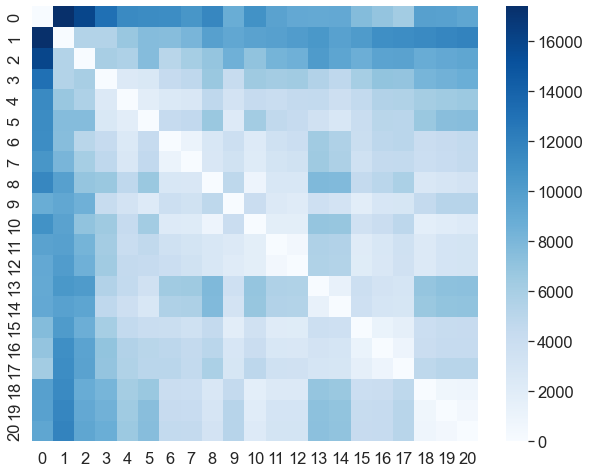

In [7]:
# plotting the heatmap of distance matrix
sns.set(font_scale=1.5)
plt.figure(figsize=(10, 8))

sns.heatmap(distance_matrix, cmap="Blues")
plt.show()

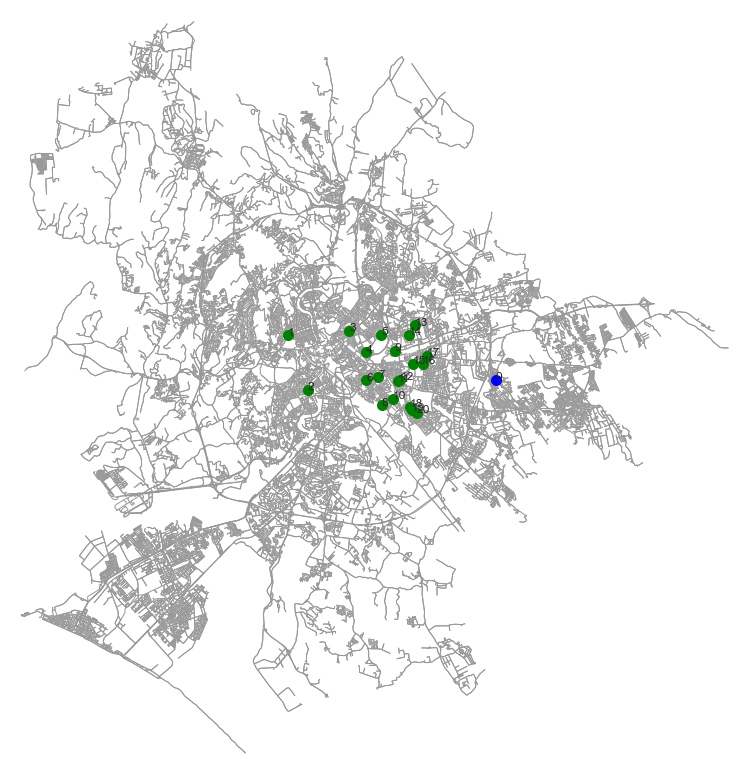

In [9]:
fig, ax = ox.plot_graph(graph, figsize=(
    14, 14), node_size=0, show=False, close=False)
ax.scatter(center_point[1], center_point[0], c='blue', s=100, zorder=2)
ax.scatter([graph.nodes[n]['x'] for n in nodes[1:]], [graph.nodes[n]['y']
           for n in nodes[1:]], c='green', s=100, zorder=2)
for i, node in enumerate(nodes):
    ax.text(graph.nodes[node]['x'], graph.nodes[node]
            ['y'], str(i), fontsize=12)


ax.axis('off')
plt.show()

Here is the above map but zooming for more details.

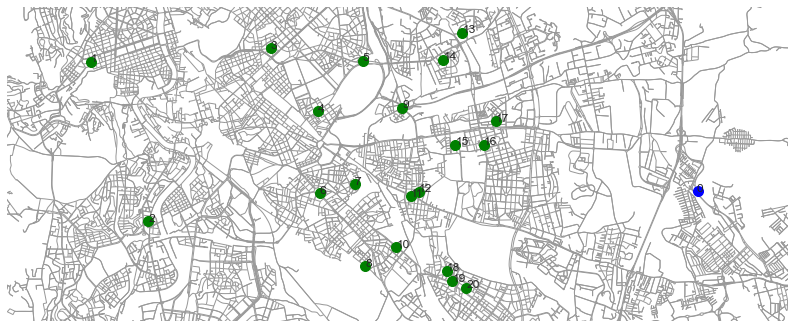

In [10]:
fig, ax = ox.plot_graph(graph, figsize=(
    14, 14), node_size=0, show=False, close=False)
ax.scatter(center_point[1], center_point[0], c='blue', s=100, zorder=2)
ax.scatter([graph.nodes[n]['x'] for n in nodes[1:]], [graph.nodes[n]['y']
           for n in nodes[1:]], c='green', s=100, zorder=2)
for i, node in enumerate(nodes):
    ax.text(graph.nodes[node]['x'], graph.nodes[node]
            ['y'], str(i), fontsize=12)

ax.set_xlim(12.428, 12.645)
ax.set_ylim(41.855, 41.92)

ax.axis('off')
plt.show()

### Create the routing model

In [137]:
ds = np.round(distance_matrix)

def create_data_model():
    """Stores the data for the problem."""
    data = {}
    data['distance_matrix'] = ds
    data['num_vehicles'] = 3
    data['depot'] = 0
    return data

In [138]:
data = create_data_model()
manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']),
                                       data['num_vehicles'], data['depot'])
routing = pywrapcp.RoutingModel(manager)

### Create the distance callback

In [139]:
def distance_callback(from_index, to_index):
    """Returns the distance between the two nodes."""
    # Convert from routing variable Index to distance matrix NodeIndex.
    from_node = manager.IndexToNode(from_index)
    to_node = manager.IndexToNode(to_index)
    return data['distance_matrix'][from_node][to_node]


transit_callback_index = routing.RegisterTransitCallback(distance_callback)

### Set the cost of travel

In [140]:
routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

In [141]:
# Add Distance constraint.
dimension_name = 'Distance'
routing.AddDimension(
    transit_callback_index,
    0,  # no slack
    400000,  # vehicle maximum travel distance
    True,  # start cumul to zero
    dimension_name)
distance_dimension = routing.GetDimensionOrDie(dimension_name)
distance_dimension.SetGlobalSpanCostCoefficient(100)

### Set search parameters (PATH_CHEAPEST_ARC)

Here I choose the PATH_CHEAPEST_ARC, however you can try the other methods that are defined in: https://developers.google.com/optimization/routing/routing_options#first_solution_strategy

In [142]:
search_parameters = pywrapcp.DefaultRoutingSearchParameters()
search_parameters.first_solution_strategy = (
    routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)

### Add the solution printer

In [143]:
def print_solution(data, manager, routing, solution):
    """Prints solution on console."""
    print(f'Objective: {solution.ObjectiveValue()}')
    max_route_distance = 0
    for vehicle_id in range(data['num_vehicles']):
        index = routing.Start(vehicle_id)
        plan_output = 'Route for vehicle {}:\n'.format(vehicle_id)
        route_distance = 0
        while not routing.IsEnd(index):
            plan_output += ' {} -> '.format(manager.IndexToNode(index))
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(
                previous_index, index, vehicle_id)
        plan_output += '{}\n'.format(manager.IndexToNode(index))
        plan_output += 'Distance of the route: {}m\n'.format(route_distance)
        print(plan_output)
        max_route_distance = max(route_distance, max_route_distance)
    print('Maximum of the route distances: {}m'.format(max_route_distance))

### Solve and print the solution

In [144]:
# Solve the problem.
solution = routing.SolveWithParameters(search_parameters)

# Print solution on console.
if solution:
    print_solution(data, manager, routing, solution)
else:
    print('No solution found !')

Objective: 3685534
Route for vehicle 0:
 0 ->  17 ->  6 ->  2 ->  11 ->  12 ->  15 ->  16 -> 0
Distance of the route: 35176m

Route for vehicle 1:
 0 ->  13 ->  14 ->  5 ->  4 ->  7 ->  8 ->  10 ->  18 ->  19 ->  20 -> 0
Distance of the route: 33649m

Route for vehicle 2:
 0 ->  9 ->  3 ->  1 -> 0
Distance of the route: 35809m

Maximum of the route distances: 35809m


### creating the list of routes

In [145]:
def get_routes(solution, routing, manager):
    """Get vehicle routes from a solution and store them in an array."""
    # Get vehicle routes and store them in a two dimensional array whose
    # i,j entry is the jth location visited by vehicle i along its route.
    routes = []
    for route_nbr in range(routing.vehicles()):
        index = routing.Start(route_nbr)
        route = [manager.IndexToNode(index)]
        while not routing.IsEnd(index):
            index = solution.Value(routing.NextVar(index))
            route.append(manager.IndexToNode(index))
        routes.append(route)
    return routes

In [146]:
routes = get_routes(solution, routing, manager)
# Display the routes.
for i, route in enumerate(routes):
    print('Route', i+1, route)

Route 1 [0, 17, 6, 2, 11, 12, 15, 16, 0]
Route 2 [0, 13, 14, 5, 4, 7, 8, 10, 18, 19, 20, 0]
Route 3 [0, 9, 3, 1, 0]


C:\Users\fadak\AppData\Local\Temp/ipykernel_13324/3885186219.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10', len(route)-1)  # Create a colormap with the same length as the number of segments


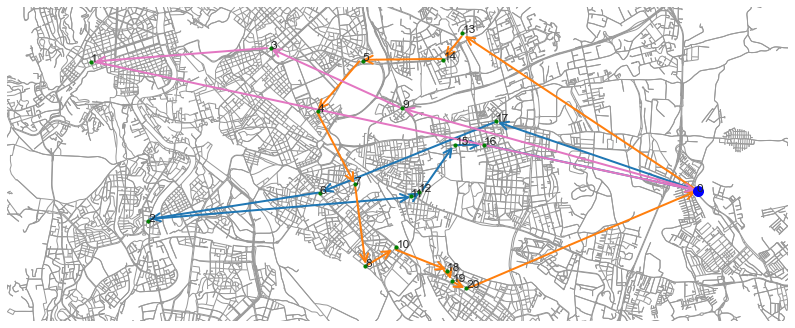

In [147]:
fig, ax = ox.plot_graph(graph, figsize=(
    14, 14), node_size=0, show=False, close=False)
ax.scatter(center_point[1], center_point[0], c='blue', s=100, zorder=2)
ax.scatter([graph.nodes[n]['x'] for n in nodes[1:]], [graph.nodes[n]['y']
           for n in nodes[1:]], c='green', s=10, zorder=2)
for i, node in enumerate(nodes):
    ax.text(graph.nodes[node]['x'], graph.nodes[node]
            ['y'], str(i), fontsize=12)
    
# Define the order of the nodes to connect
for j, route in enumerate(routes):
    cmap = cm.get_cmap('tab10', len(route)-1)  # Create a colormap with the same length as the number of segments
    color = cmap(j)  # Get the color for the current segment
    # Plot the lines between the nodes in the specified order
    for i in range(len(route) - 1):
        arrow = FancyArrowPatch((points[route[i]][1], points[route[i]][0]), (points[route[i+1]][1], points[route[i+1]][0]),
                                arrowstyle='->', color=color , linewidth=2, mutation_scale=20)
        ax.add_patch(arrow)    
        
# Set the limits of the x-axis and y-axis to zoom in on a specific part of the plot
ax.set_xlim(12.428, 12.645)
ax.set_ylim(41.855, 41.92)

ax.axis('off')
plt.show()